# See Whether Molecular Dynamics Works
We want to make sure that molecular dynamics with our new model still produces reasonable structures

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from fff.simulation import run_calculator
from fff.sampling.md import MolecularDynamics
from fff.learning.gc.ase import SchnetCalculator
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.db import connect
from ttm.ase import TTMCalculator
from tqdm import tqdm
import pickle as pkl
import numpy as np
import warnings
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configure the DFT methods

## Get a starting structure
Just a random structure to start with

In [2]:
with connect('../../initial-database/initial-psi4.db') as db:
    atoms = next(db.select('', limit=1)).toatoms()
atoms

Atoms(symbols='OH2OH2OH2OH2', pbc=False, calculator=SinglePointCalculator(...))

## Make the SchNet and Psi4 Calculators
We're going to compare their performance

In [3]:
%%time
calc = TTMCalculator()
ttm_eng = calc.get_potential_energy(atoms)

CPU times: user 627 µs, sys: 60 µs, total: 687 µs
Wall time: 651 µs


In [4]:
with open('tuned/model', 'rb') as fp:
    model = torch.load(fp, map_location='cpu')
ml_calc = SchnetCalculator(model)
ml_eng = ml_calc.get_potential_energy(atoms)

In [5]:
print(f'Energy of starting geom - Psi4: {ttm_eng:.1f}, SchNet: {ml_eng:.1f} eV. Error: {(ttm_eng - ml_eng) * 1000:.1f} meV')

Energy of starting geom - Psi4: -0.9, SchNet: -0.8 eV. Error: -52.8 meV


Off by a few meV, which is pretty good

## Check whether MD samples structures with reasonable energies


In [6]:
%%time
MaxwellBoltzmannDistribution(atoms, temperature_K=100)
_, traj = MolecularDynamics().run_sampling(atoms, 10000, ml_calc, log_interval=50, timestep=0.1)

CPU times: user 6min 33s, sys: 4.6 s, total: 6min 37s
Wall time: 33.2 s


In [7]:
%%time
spk_energies = [a.get_potential_energy() for a in traj]

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 17.2 ms


Get the energies using TTM

In [8]:
ttm_energies = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for a in tqdm(traj):
        try:
            psi4_eng = calc.get_potential_energy(a)
        except BaseException:
            psi4_eng = np.nan
        ttm_energies.append(psi4_eng)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 4825.95it/s]


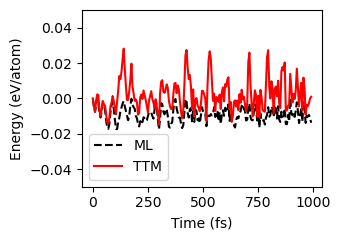

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot them normalized such that they start the same
times = np.arange(len(spk_energies)) * 0.1 * 50
ax.plot(times, np.subtract(spk_energies, spk_energies[0]) / len(atoms), 'k--', label='ML')
ax.plot(times, np.subtract(ttm_energies, ttm_energies[0]) / len(atoms), 'r-', label='TTM')

ax.set_ylim(-0.05, 0.05)

ax.set_xlabel('Time (fs)')
ax.set_ylabel('Energy (eV/atom)')

ax.legend()
fig.tight_layout()

We start off with pretty similar energies, but they rapidly diverge after only a few timesteps. Molecular dynamics seemed to have found a spurious minimum! That'll be something we fix with active learning